# 1. Importing and Description of the dataset

### 1.1 Importing

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm #for adding constant and building model
#for train and test split
from sklearn.model_selection import train_test_split 
#model building

#internal validity stastistical tests and plots
from statsmodels.api import qqplot #for qq plot
from statsmodels.stats.diagnostic import het_breuschpagan,linear_rainbow  #variance equality and linearity tests
from scipy.stats import shapiro #for checking normality
from statsmodels.stats.outliers_influence import variance_inflation_factor #for checking Multicolinearity

from sklearn.tree import DecisionTreeRegressor, plot_tree

from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import *
from sklearn.linear_model import LinearRegression

from scipy import stats # for boxcox transformation 
from sklearn.preprocessing import PolynomialFeatures #for polynomial regression

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [0]:
URL = "https://raw.githubusercontent.com/TamaraSedrakyan/Data_houses.csv/master/merged_04_2020_house_price.csv"
data = pd.read_csv(URL)

### 1.2 Description

In [0]:
data.shape

(30520, 16)

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30520 entries, 0 to 30519
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Source         30520 non-null  object 
 1   Rooms          30520 non-null  float64
 2   City           30520 non-null  object 
 3   ID             30520 non-null  int64  
 4   nFloor         30519 non-null  float64
 5   Broker         10727 non-null  object 
 6   District       30520 non-null  object 
 7   Sqm            30520 non-null  float64
 8   Currency       30520 non-null  object 
 9   Agency         30520 non-null  float64
 10  Price          30520 non-null  float64
 11  HTML_ID        30520 non-null  int64  
 12  Type           30520 non-null  object 
 13  Floor          30519 non-null  object 
 14  Price_USD      30520 non-null  float64
 15  price_per_sqm  30520 non-null  float64
dtypes: float64(7), int64(2), object(7)
memory usage: 3.7+ MB


In [0]:
data.describe() 

,Rooms,nFloor,Sqm,Floor,Price_USD,price_per_sqm
count,28440.000000,28440.000000,28440.000000,28440.000000,2.844000e+04,28440.000000
mean,2.714416,8.511709,83.076619,5.068776,1.090309e+05,1267.724189
std,0.972141,4.115539,35.129598,3.450307,9.056531e+04,633.628019
min,1.000000,1.000000,15.000000,0.000000,1.000000e+03,32.080000
25%,2.000000,5.000000,61.000000,2.000000,5.700000e+04,833.330000
50%,3.000000,9.000000,78.000000,4.000000,7.900000e+04,1063.390000
75%,3.000000,11.000000,96.000000,7.000000,1.300000e+05,1500.000000
max,7.000000,25.000000,300.000000,23.000000,1.300000e+06,5000.000000


In [0]:
print("Number of Null values:",data.isnull().sum().sum())
print("Number of duplicates:",data.duplicated().sum())
print("Single valued columns:", data.columns[data.nunique() ==1])

Number of Null values: 19795
Number of duplicates: 0
Single valued columns: Index([], dtype='object')


In [0]:
for col_name in data.select_dtypes(include='object').columns:
    var_cat = data[col_name].value_counts()
    print(col_name, "\n", var_cat, "\n", "\n")
    print("____________________")

Source 
 list_am        19793
my_realty       7588
real_estate     3139
Name: Source, dtype: int64 
 

____________________
City 
 երևան      19084
Երևան      10727
yerevan      568
ереван       136
erevan         5
Name: City, dtype: int64 
 

____________________
Broker 
 գործակալություն    4140
գործակալ           3448
ԿԵՆՏՐՈՆ             891
Գրիգոր              316
ՆվերՎանեսյան        315
Աղաս                258
ՆաիրաԴանիելյան      229
Արզուման            207
Արամ                192
Արիս                171
Գայանե              152
Նարեկ               113
ՎահեԴանիելյան        92
Լիլիթ                69
ՍևակՄելիքսեթյան      60
ՏիգրանԹավադյան       36
Սյուզի               21
Գևորգ                17
Name: Broker, dtype: int64 
 

____________________
District 
 կենտրոն             9730
արաբկիր             6025
շենգավիթ            2867
աջափնյակ            2193
0                   2079
նորք                1665
մալաթիա             1472
դավթաշեն            1353
ավան                 994
քանաք

# 2. Cleaning the dataset

In [0]:
#Dropping City variable which has only onne unique variable represented in different languages. It cannot contribute to out model building in any way. 
#Dropping variable ID
#Price and Currency will also be dropped, because we have a column Price_USD, which will be enough for our alaysis and tehre will be no need to convert everything to dollor
data = data.drop(['City', 'ID', 'HTML_ID', 'Price','Currency'], axis = 1)

In [0]:
data.drop(data.loc[data['Type']=='Փայտե'].index, inplace=True)

In [0]:
#As there are multiple entries of some categories, we filter them and make into one. 
data.District.replace({'քանաքեռ':'քանաքեռ_զեյթուն','մալաթիա':'մալաթիա_սեբաստիա','նորք':'նոր_նորք', '0': 'Չկա', 'այլ': None}, inplace = True)
data.Floor.replace({ 'Նկուղ ': '0'}, inplace = True)
data.Broker.replace({None: 'այլ'}, inplace = True)
data.Agency = data.Agency.astype('category')

In [205]:
print("District categories:",data.District.unique())
print("Floor categories:", pd.to_numeric(data.Floor).unique())

District categories: ['կենտրոն' 'աջափնյակ' 'ավան' 'արաբկիր' 'դավթաշեն' 'էրեբունի' 'նոր_նորք'
 'մալաթիա_սեբաստիա' 'քանաքեռ_զեյթուն' 'շենգավիթ' None 'Չկա']
Floor categories: [ 7.  2.  4.  1.  6.  9.  5.  3.  8. 11. 16. 17. 13. 14. 10. 15. 12. 19.
 18. 21. 22. 20.  0. 23. nan]


In [0]:
#We should make the rooms variable into categorical, as it can take limited number of inputs. 
## data.Rooms = data.Rooms.astype('category')   
data.Floor = pd.to_numeric(data.Floor) ##.astype('category') 
data.District = data.District.astype("category")

In [0]:
print("Use of agency \n",data.Agency.value_counts())
print("__________________")
print("Flats in each floor \n",data.Floor.value_counts().sort_index())
#We can see that most of recordings indicated the use of agency. 
print("Number of floors of the buildings \n", data.nFloor.value_counts().sort_index())
print("Number of flats in each District \n", data.District.value_counts())

Use of agency 
 1.0    29650
0.0      869
Name: Agency, dtype: int64
__________________
Flats in each floor 
 0.0        6
1.0     3219
2.0     4561
3.0     4117
4.0     4629
5.0     4186
6.0     1669
7.0     1434
8.0     1718
9.0     1678
10.0     730
11.0     535
12.0     609
13.0     452
14.0     456
15.0     211
16.0     154
17.0      85
18.0      36
19.0       7
20.0       5
21.0      13
22.0       6
23.0       2
Name: Floor, dtype: int64
Number of floors of the buildings 
 1.0       25
2.0      109
3.0      567
4.0     3459
5.0     8207
6.0      904
7.0      560
8.0      565
9.0     6619
10.0    1654
11.0     849
12.0    1312
13.0     401
14.0    2164
15.0     491
16.0    1736
17.0     356
18.0     214
19.0      84
20.0      50
21.0      41
22.0      74
23.0      70
24.0       3
25.0       4
Name: nFloor, dtype: int64
Number of flats in each District 
 կենտրոն             9730
արաբկիր             6025
շենգավիթ            2866
աջափնյակ            2193
նոր_նորք            2138
Չկա 

# 3. Visualization of the dataset

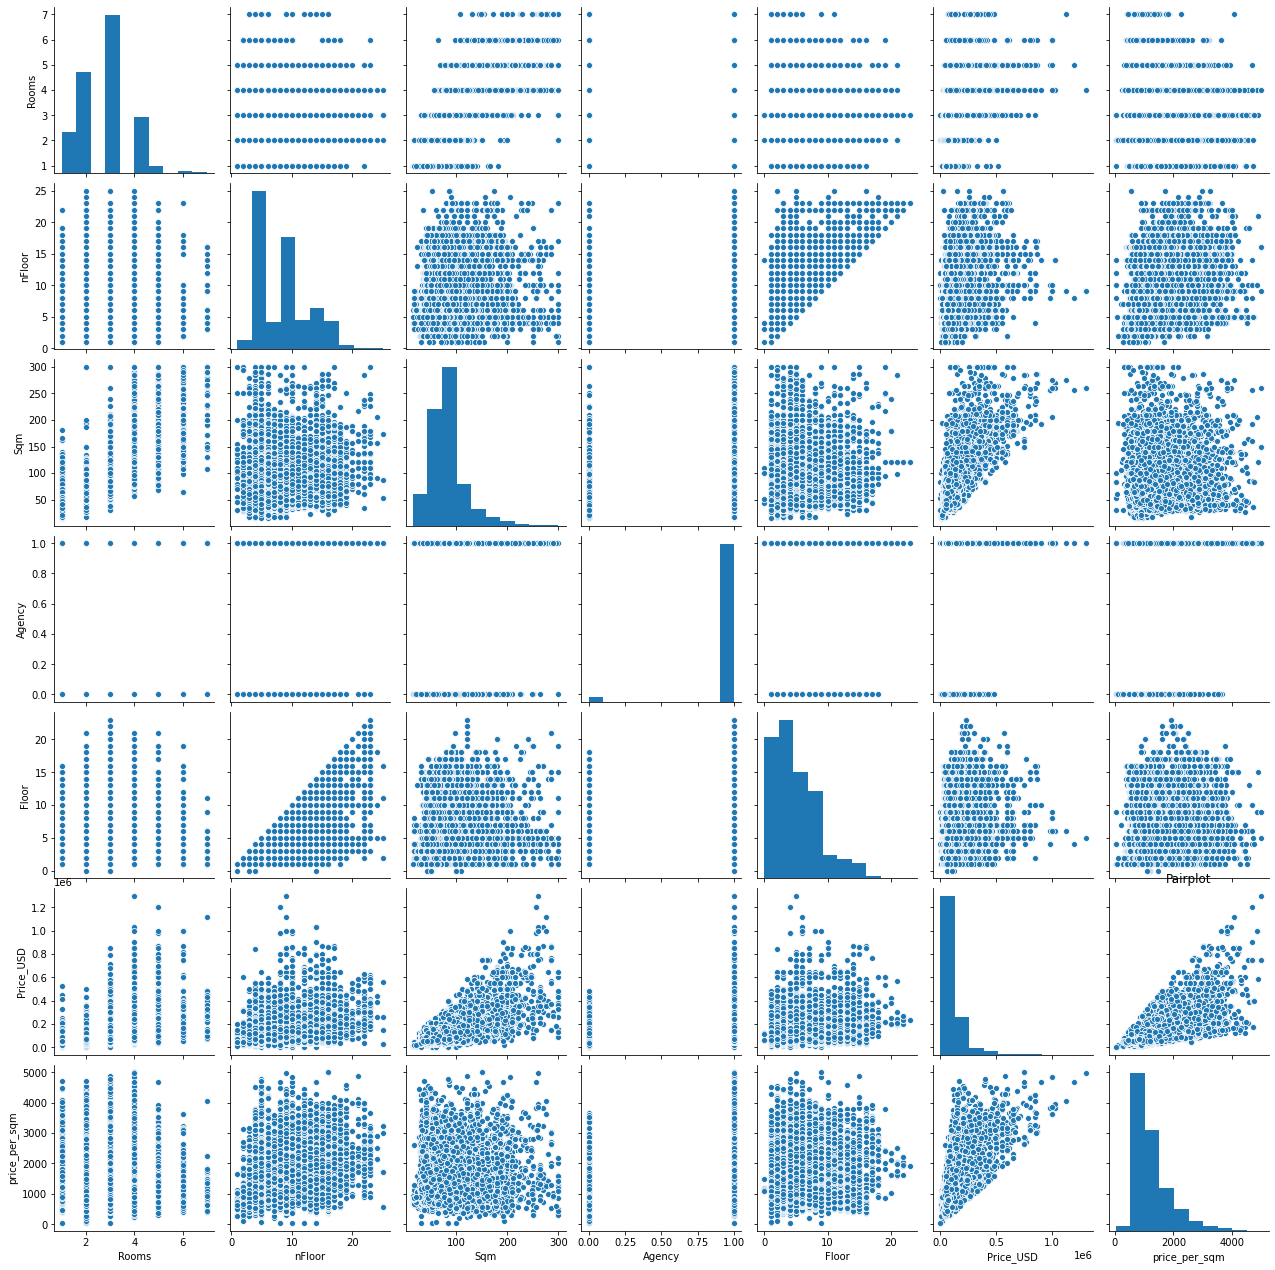

In [0]:
#Creating a pairplot to see the distribution of the variables and grpahical relationship between them. 
sns.pairplot(data)
plt.title("Pairplot")
plt.show()

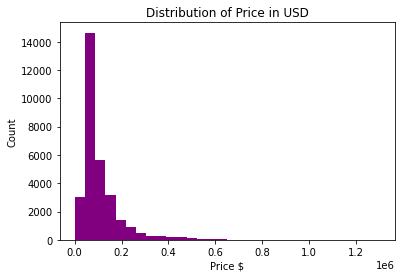

In [0]:
#Visualizing the distribution of our dependent variable: price
plt.hist(data.Price_USD,bins=30, color='purple')
plt.title("Distribution of Price in USD")
plt.xlabel("Price $")
plt.ylabel("Count")
plt.show()


We can see that our dependennt variable follows a right skewed distribution, which mean that we can bring it to more normal scale by taking logarithm of it. 

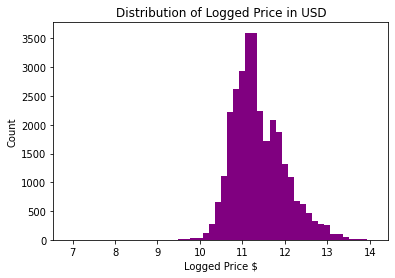

In [0]:
plt.hist(np.log(data.Price_USD), color = 'purple', bins = 50)
plt.title("Distribution of Logged Price in USD")
plt.xlabel("Logged Price $")
plt.ylabel("Count")
plt.show()
#Logarithmic function makes the distribution more normal. 


In [0]:
data["Price_box"], _ = stats.boxcox(data.Price_USD)
#We can see that through boxcox transformation we got higher normal distribution

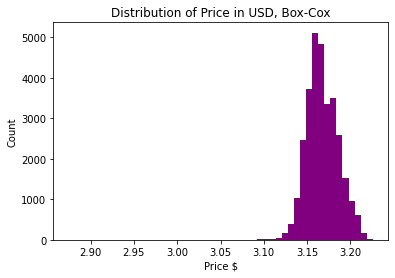

In [0]:
plt.hist(data.Price_box, color = 'purple', bins = 50)
plt.title("Distribution of Price in USD, Box-Cox")
plt.xlabel("Price $")
plt.ylabel("Count")
plt.show()


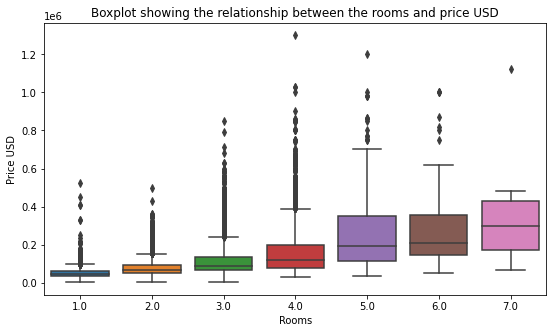

In [0]:
plt.figure(figsize=(9,5))
sns.boxplot(x = data.Rooms, y = data.Price_USD)
plt.title("Boxplot showing the relationship between the rooms and price USD")
plt.ylabel("Price USD")
plt.show()
#However later we tried and the accuracy was better with log compared to boxcox transformation

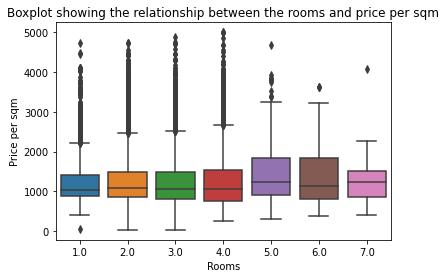

In [0]:
sns.boxplot(x = data.Rooms, y = data.price_per_sqm)
plt.title("Boxplot showing the relationship between the rooms and price per sqm")
plt.ylabel("Price per sqm")
plt.show()


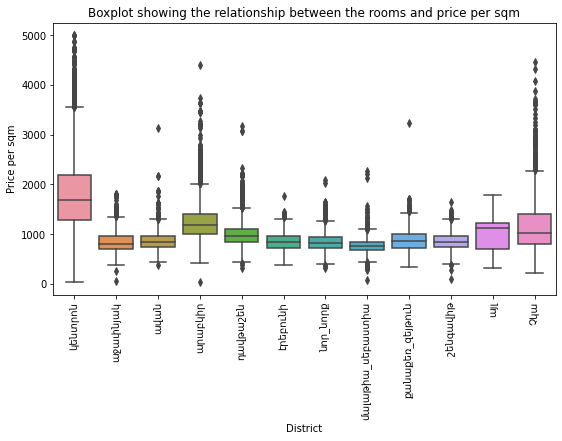

In [0]:
plt.figure(figsize=(9,5))
sns.boxplot(x = data.District, y = data.price_per_sqm)
plt.title("Boxplot showing the relationship between the rooms and price per sqm")
plt.ylabel("Price per sqm")
plt.xticks(rotation='vertical')
plt.show()



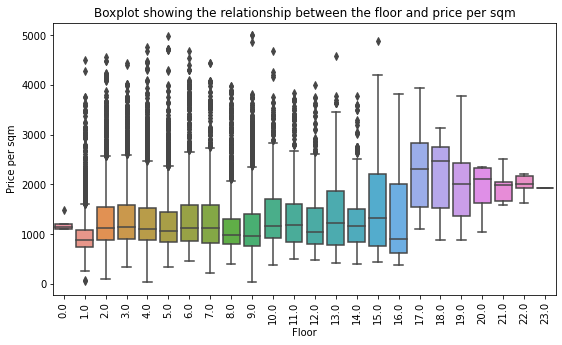

In [0]:
#the floor and the price
plt.figure(figsize=(9,5))
sns.boxplot(x = data.Floor, y = data.price_per_sqm)
plt.title("Boxplot showing the relationship between the floor and price per sqm")
plt.ylabel("Price per sqm")
plt.xticks(rotation='vertical')
plt.show()

We can see that although there are many outliers, flats in higher floors are more expensive per sqm. 

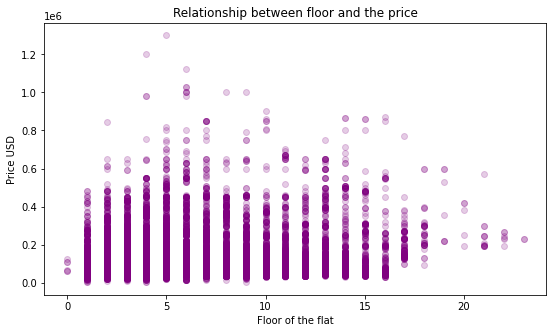

In [0]:
plt.figure(figsize=(9,5))
plt.scatter(y = data.Price_USD, x = pd.to_numeric(data.Floor), alpha=0.2, color = 'purple')
plt.xlabel("Floor of the flat")
plt.ylabel("Price USD")
plt.title("Relationship between floor and the price")
plt.show()

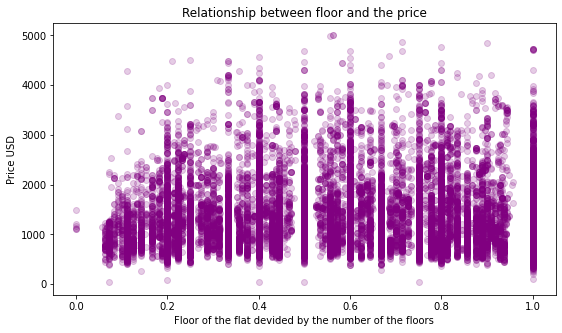

In [0]:
plt.figure(figsize=(9,5))
plt.scatter(y = data.price_per_sqm, x = pd.to_numeric(data.Floor)/pd.to_numeric(data.nFloor), alpha=0.2, color = 'purple')
plt.xlabel("Floor of the flat devided by the number of the floors")
plt.ylabel("Price USD")
plt.title("Relationship between floor/nFloor and the price")
plt.show()

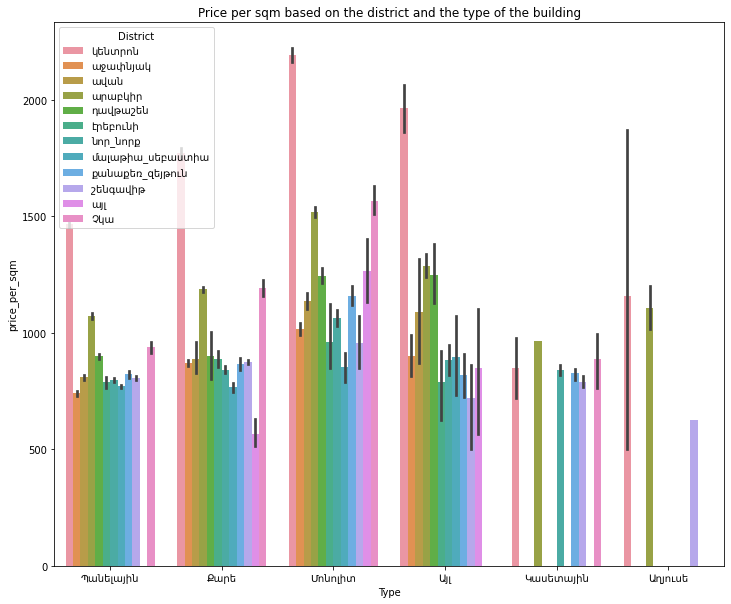

In [0]:
plt.figure(figsize=(12,10))
sns.barplot(data = data, x = 'Type', y = 'price_per_sqm', hue = 'District')
plt.title("Price per sqm based on the district and the type of the building")
plt.show()

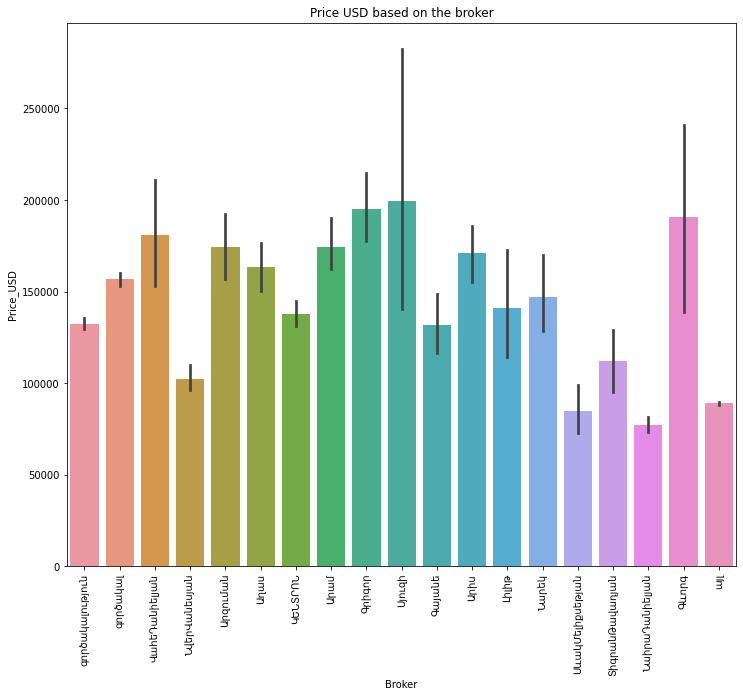

In [0]:
plt.figure(figsize=(12,10))
sns.barplot(data = data, x = 'Broker', y = 'Price_USD')
plt.title("Price USD based on the broker")
plt.xticks(rotation='vertical')
plt.show()

According to the graph we can see that there are some ranges of USD prices that each broker works with. So we will try to group them. 

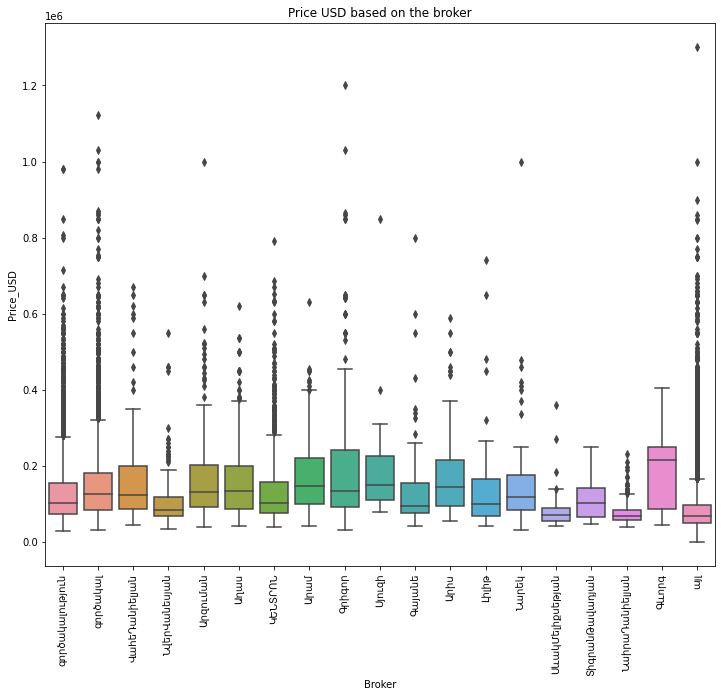

In [0]:
plt.figure(figsize=(12,10))
sns.boxplot(data = data, x = 'Broker', y = 'Price_USD')
plt.title("Price USD based on the broker")
plt.xticks(rotation='vertical')
plt.show()

In [0]:
mapping = {'ՆվերՎանեսյան':1,'ՍևակՄելիքսեթյան':1,'ՆաիրաԴանիելյան':1,'ՏիգրանԹավադյան':1,'այլ':1, 'NaN':1,
           'գործակալություն':2,'ԿԵՆՏՐՈՆ':2,'Գայանե':2,'Լիլիթ':2,'Նարեկ':2,
           'գործակալ':3,'ՎահեԴանիելյան':3,'Արզուման':3,'Աղաս':3,'Արամ':3,'Արիս':3,
           'Գրիգոր':4,'Սյուզի':4,'Գևորգ':4}
data["Broker_tr"] = data.Broker.map(mapping)


In [0]:
data.Broker_tr = pd.Categorical(data.Broker_tr)
data.Broker_tr.unique()

[2, 3, 1, 4]
Categories (4, int64): [2, 3, 1, 4]

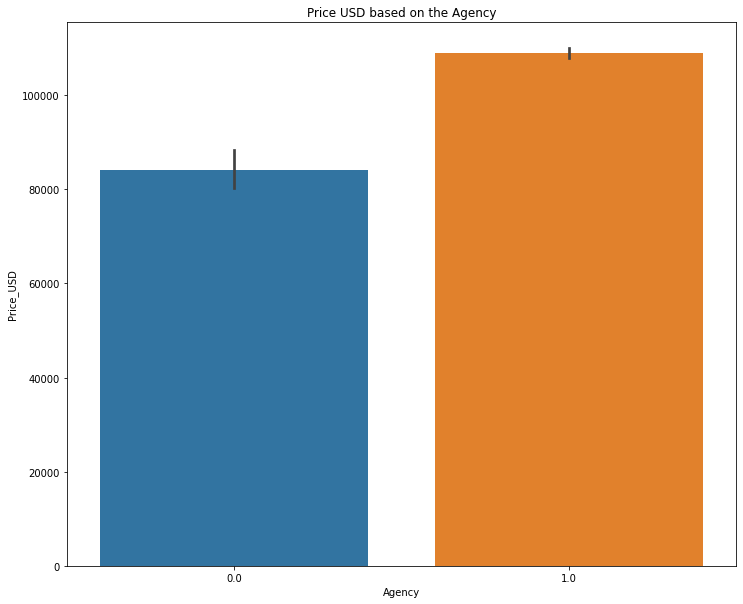

In [0]:
plt.figure(figsize=(12,10))
sns.barplot(data = data, x = 'Agency', y = 'Price_USD')
plt.title("Price USD based on the Agency")
plt.show()

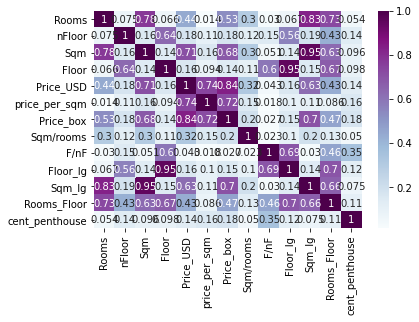

In [0]:
sns.heatmap(data.corr().abs(), cmap = 'BuPu', annot= True)
plt.show()

 We will drop price per sqm meter variable. We will also drop the vraible rooms, as it had high correlation with sqm. We will try to reflect the influence of the variables that we dropped by creating interaction terms. After this, We can see that there is no multicollinearity, as other variables besides the Price_USD does not have high correlation with each other. 

# 4. Constructing Models


### 4.1 Linear Regression Model

In [270]:
data = data.dropna()
data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30483 entries, 0 to 30519
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Source         30483 non-null  object  
 1   Rooms          30483 non-null  float64 
 2   nFloor         30483 non-null  float64 
 3   Broker         30483 non-null  object  
 4   District       30483 non-null  category
 5   Sqm            30483 non-null  float64 
 6   Agency         30483 non-null  category
 7   Type           30483 non-null  object  
 8   Floor          30483 non-null  float64 
 9   Price_USD      30483 non-null  float64 
 10  price_per_sqm  30483 non-null  float64 
dtypes: category(2), float64(6), object(3)
memory usage: 2.4+ MB


In [0]:
#Here we create two new variables that maybe significant for the prediction: the sqm per room and the floor's proportion from the N floor building. 
#Also we logaritm two variables sqm and floor to resume normal distribution. 
data["Sqm/rooms"] = data.Sqm/ data.Rooms
data["F/nF"] = data.Floor/data.nFloor #not significant 
data['Floor_lg'] = np.log1p(data.Floor) #loging makes it insignificant 
data['Sqm_lg'] = np.log(data.Sqm)
data['Rooms_Floor'] = data.Rooms*data.Floor_lg 
data['nFloor_lg'] = np.log1p(data.nFloor)
#Logingg Floor variable didn;t increase the accuracy and was not a significant variable

In [272]:
print(data['nFloor'].corr(data['Floor']))
print(data['Sqm'].corr(data['Sqm/rooms']))
print(data['Rooms'].corr(data['Sqm/rooms']))

0.6354513948913824
0.3028031186073272
-0.29972870116735806


In [0]:
data["cent_penthouse"] = ((data['Floor']/data['nFloor'] == 1) & (data.District == 'կենտրոն')).map({True: 1, False: 0})

In [282]:
data_ols = data[['nFloor', "Sqm_lg", 'Floor', 'Price_USD',"Sqm/rooms"]]
data_ols = pd.concat((data_ols, pd.get_dummies(data[["Source", "District", "Type",'Agency', "cent_penthouse"]], drop_first=True)), axis =1)
data_ols.head(2)

,nFloor,Sqm_lg,Floor,Price_USD,Sqm/rooms,cent_penthouse,Source_my_realty,Source_real_estate,District_աջափնյակ,District_ավան,District_արաբկիր,District_դավթաշեն,District_էրեբունի,District_կենտրոն,District_մալաթիա_սեբաստիա,District_նոր_նորք,District_շենգավիթ,District_քանաքեռ_զեյթուն,Type_Այլ,Type_Կասետային,Type_Մոնոլիտ,Type_Պանելային,Type_Քարե,Agency_1.0
0,16.0,4.382027,7.0,85000.0,26.666667,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1
1,4.0,4.709530,2.0,72000.0,27.750000,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1


In [0]:
#as we already saw, the Price_USD has right skewed distribution, so we need to normalize it. 
Y = np.log(data_ols.Price_USD)
#Y = data.Price_box
X = data_ols.drop(["Price_USD"],axis = 1)


In [0]:
X_1 = sm.add_constant(X)

In [0]:
model_linear = sm.OLS(Y,X_1)

In [0]:
results_linear = model_linear.fit()

In [287]:
results_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Price_USD   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     5164.
Date:                Fri, 15 May 2020   Prob (F-statistic):               0.00
Time:                        18:19:29   Log-Likelihood:                -3830.8
No. Observations:               30483   AIC:                             7710.
Df Residuals:                   30459   BIC:                             7909.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         7.3486      0.106     69.474      0.000       7.141       7.556
nFloor                        0.0023      0.001      3.441      0.001       0.001       0.004
Sqm_lg                        0.8112      0.004    184.796      0.000       0.803       0.820
Floor                        -0.0008      0.001     -1.244      0.213      -0.002       0.000
Sqm/rooms                     0.0013      0.000      6.720      0.000       0.001       0.002
cent_penthouse               -0.0857      0.007    -11.794      0.000      -0.100      -0.071
Source_my_realty              0.0805      0.004     19.567      0.000       0.072       0.089
Source_real_estate            0.0867      0.006     15.572      0.000       0.076       0.098
District_աջափնյակ            -0.3028      0.008    -35.668      0.000      -0.319      -0.286
District_ավան                -0.2034      0.011    -18.977      0.000      -0.224      -0.182
District_արաբկիր              0.0514      0.007      7.112      0.000       0.037       0.066
District_դավթաշեն            -0.1036      0.010    -10.563      0.000      -0.123      -0.084
District_էրեբունի            -0.2631      0.016    -16.271      0.000      -0.295      -0.231
District_կենտրոն              0.4093      0.007     57.869      0.000       0.395       0.423
District_մալաթիա_սեբաստիա    -0.2690      0.009    -29.374      0.000      -0.287      -0.251
District_նոր_նորք            -0.2568      0.009    -29.839      0.000      -0.274      -0.240
District_շենգավիթ            -0.2503      0.008    -31.195      0.000      -0.266      -0.235
District_քանաքեռ_զեյթուն     -0.2319      0.010    -22.443      0.000      -0.252      -0.212
Type_Այլ                      0.4198      0.105      4.015      0.000       0.215       0.625
Type_Կասետային                0.2598      0.106      2.454      0.014       0.052       0.467
Type_Մոնոլիտ                  0.5941      0.104      5.717      0.000       0.390       0.798
Type_Պանելային                0.2340      0.104      2.253      0.024       0.030       0.438
Type_Քարե                     0.3642      0.104      3.508      0.000       0.161       0.568
Agency_1.0                    0.0306      0.010      3.184      0.001       0.012       0.049
==============================================================================
Omnibus:                     3945.581   Durbin-Watson:                   1.791
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40561.009
Skew:                          -0.242   Prob(JB):                         0.00
Kurtosis:                       8.630   Cond. No.                     5.57e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the

We have done backward elemenation. All the above variables were used in the model after doing careful feature engineering. 
This is the best model we were able to achieve with R-square 79.6 using one featured polynomial regression. 

### 4.2 External Validation: Train/Test Split

In [0]:
X0, X1, Y0, Y1 = train_test_split(X, Y, test_size=0.25, random_state=42)

In [0]:
#Applying already on test and train splits
model_linear_splitted = sm.OLS(Y0,X0)

In [0]:
results_splitted = model_linear_splitted.fit()

In [0]:
Y0_linear = results_splitted.predict(X0)
Y1_linear = results_splitted.predict(X1)

In [241]:
#let's see r-squared for train and test sets for the transformed model
print("R-squared Train:",r2_score(Y0,Y0_linear).round(3))
print("R-squared Test:",r2_score(Y1,Y1_linear).round(3))

R-squared Train: 0.758
R-squared Test: 0.779


### 4.3 Polynomial Regression

In [0]:
poly_reg = PolynomialFeatures(degree=2)
X0_poly = poly_reg.fit_transform(X0)
X1_poly = poly_reg.fit_transform(X1)
X_poly = poly_reg.fit_transform(X)

In [0]:
model_poly = LinearRegression().fit(X0_poly,Y0)

In [0]:
Y0_pred_poly = model_poly.predict(X0_poly)
Y1_pred_poly = model_poly.predict(X1_poly)

In [245]:
print("R-squared Train:", r2_score(Y0,Y0_pred_poly))
print("R-squared Test:", r2_score(Y1,Y1_pred_poly))

R-squared Train: 0.8125136845658718
R-squared Test: 0.8115342397567341


In [0]:
#For the tests creating 
X_poly = sm.add_constant(X_poly)
OLS_poly_results = sm.OLS(Y,X_poly).fit()

In [0]:
#OLS_poly_results.summary()

### 4.4 Linear Regression RMSE



In [0]:
lr = LinearRegression()
lr.fit(X0,Y0)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
Y1_linear = lr.predict(X1)

In [0]:
Y0_linear = lr.predict(X0)

In [0]:
MSE_train = mean_squared_error(Y0, Y0_linear)
MSE_test = mean_squared_error(Y1, Y1_linear)

In [0]:
print("MSE train", MSE_train)
print("MSE test", MSE_test)

MSE train 0.07513517261836514
MSE test 0.07580156681700864


In [0]:
np.mean(-cross_val_score(estimator = LinearRegression(), X = X, y = Y, cv = 3, scoring='neg_mean_squared_error'))

0.07931125237843706

### 4.5 Decision Tree

In [0]:
param_dt = {"max_depth":range(1,13), "min_samples_leaf":range(0,19000,200)}

In [0]:
gs_dt = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                    param_grid = param_dt,
                    cv = 3,
                    scoring = "neg_mean_squared_error", 
                    verbose=1)
gs_dt.fit(X0,Y0)

Fitting 3 folds for each of 1140 candidates, totalling 3420 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3420 out of 3420 | elapsed:   16.4s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=42, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': range(1, 13),
                         'min_samples_leaf': range(0, 19000, 200)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
      

In [0]:
gs_dt.best_params_

{'max_depth': 7, 'min_samples_leaf': 200}

In [0]:
dt_grid = DecisionTreeRegressor(max_depth=12, min_samples_leaf=200, random_state=42).fit(X0,Y0)

In [0]:
#predictions
Y0_dt_grid = dt_grid.predict(X0)
Y1_dt_grid = dt_grid.predict(X1)

In [0]:
MSE_train_dt_grid = mean_squared_error(Y0,Y0_dt_grid )
MSE_test_dt_grid = mean_squared_error(Y1,Y1_dt_grid )
print("MSE of train dataset using DT with best params", MSE_train_dt_grid)
print("MSE of test dataset using DT with best params", MSE_test_dt_grid)


MSE of train dataset using DT with best params 0.07670555356282521
MSE of test dataset using DT with best params 0.08005459699583281


In [0]:
np.mean(-cross_val_score(estimator = dt_grid, X = X, y = Y, scoring = 'neg_mean_squared_error', cv = 3))

0.08649311658720944

In [0]:
clf = DecisionTreeRegressor(random_state = 42)
clf = clf.fit(X0, Y0)
importances = clf.feature_importances_
pd.DataFrame(data = clf.feature_importances_, index=X0.columns)
#We can see the feature importances in the following table

,0
nFloor,0.042059
Sqm_lg,0.522349
Floor,0.041645
Sqm/rooms,0.043230
cent_penthouse,0.002475
Source_my_realty,0.005244
Source_real_estate,0.003738
District_աջափնյակ,0.003406
District_ավան,0.001258
District_արաբկիր,0.046162


Plotting the desicion tree


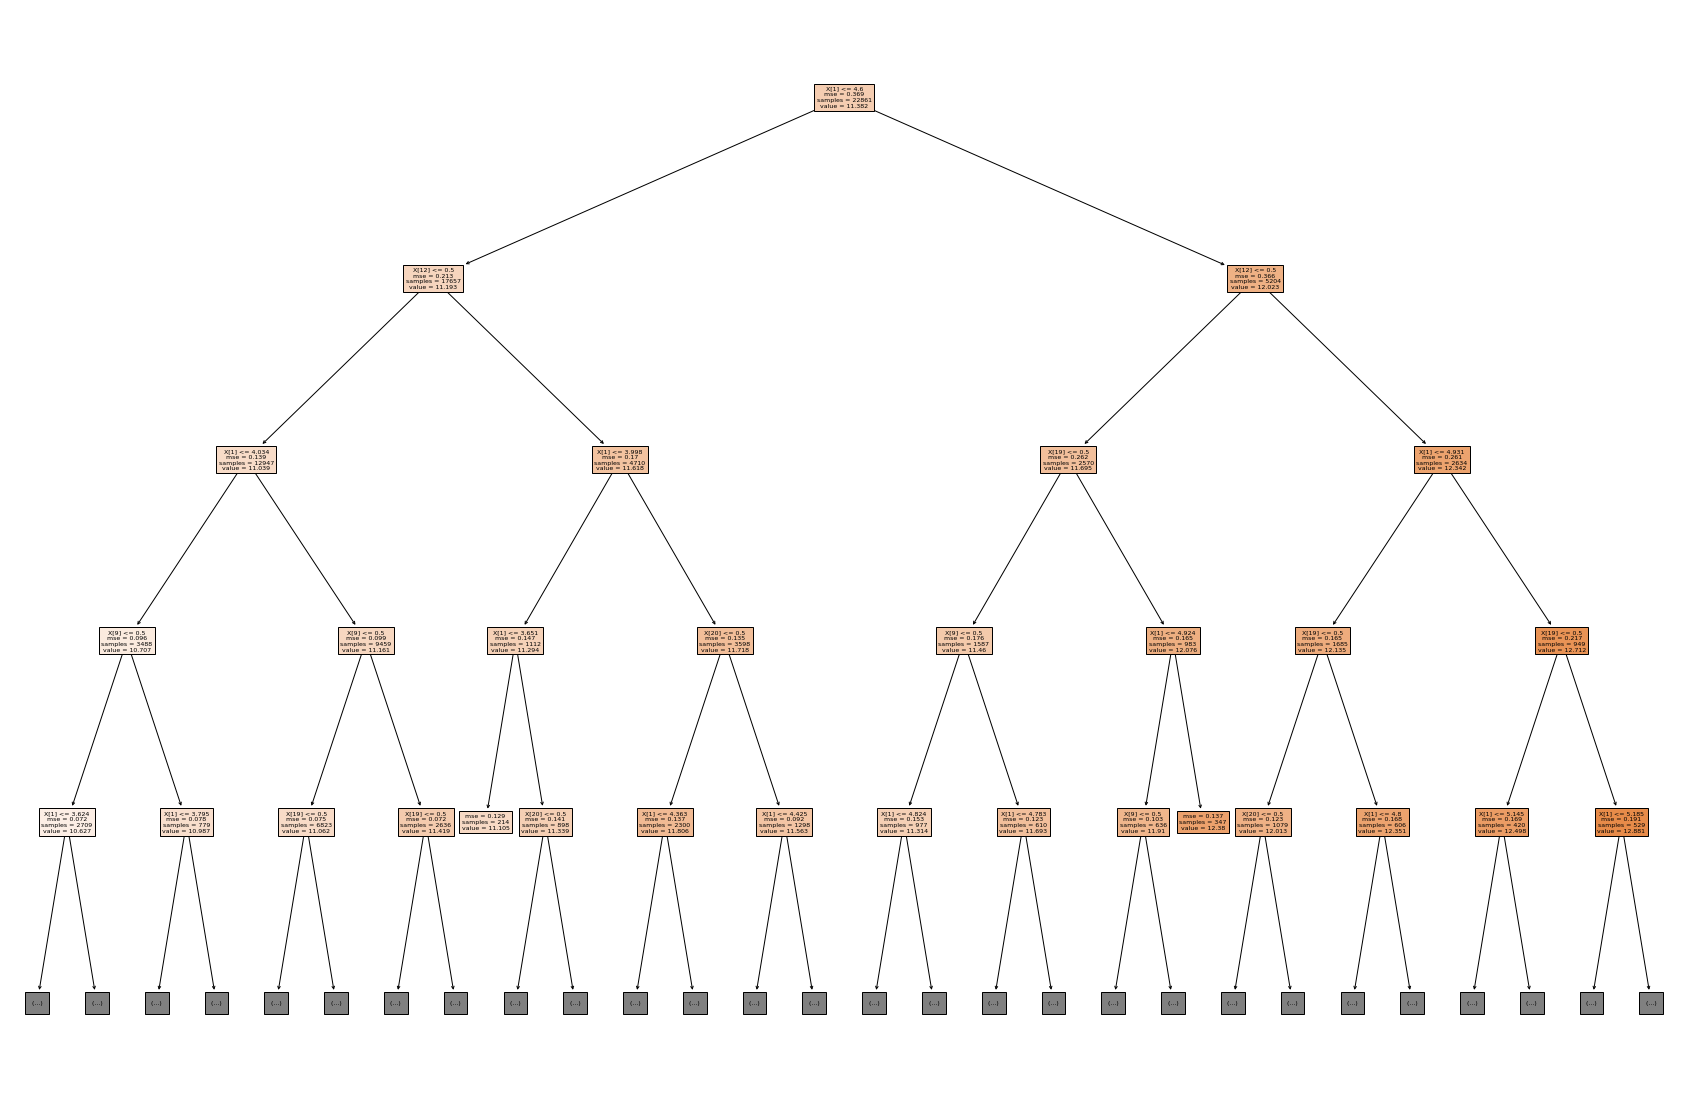

In [0]:
plt.figure(figsize = (30,20))
plot_tree(dt_grid,
         filled=True)
plt.show()

Random Forest

In [0]:
gs_rf = GridSearchCV(estimator=RandomForestRegressor(random_state = 42),
                    param_grid=param_dt,
                    cv = 3,
                    scoring = 'neg_mean_squared_error', 
                    verbose = True, 
                    n_jobs = -1)

In [0]:
gs_rf.fit(X0,Y0)

Fitting 3 folds for each of 1140 candidates, totalling 3420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  3.0min


KeyboardInterrupt: ignored

In [0]:
gs_rf.best_params_

{'max_depth': 6, 'min_samples_leaf': 200}

In [0]:
rf_grid = RandomForestRegressor(max_depth = 11, min_samples_leaf = 200, random_state = 42).fit(X0, Y0)

In [0]:
Y0_rf_grid = rf_grid.predict(X0)
Y1_rf_grid = rf_grid.predict(X1)

In [0]:
MSE_train_rf_grid = mean_squared_error(Y0, Y0_rf_grid)
MSE_test_rf_grid =mean_squared_error(Y1, Y1_rf_grid)
print("MSE Train RF Grid:", MSE_train_rf_grid)
print("MSE Test RF Grid:", MSE_test_rf_grid)

MSE Train RF Grid: 0.07984840798532872
MSE Test RF Grid: 0.08270652524867435


In [0]:
np.mean(-cross_val_score(estimator = rf_grid, X = X, y = Y, scoring = 'neg_mean_squared_error', cv = 3))

0.08809136336909414

# 5. LINE assumption validation

#### 5.1 Visual Representation

In [0]:
#residuals of the model
residuals=results_linear.resid
predicted_values=results_linear.predict()


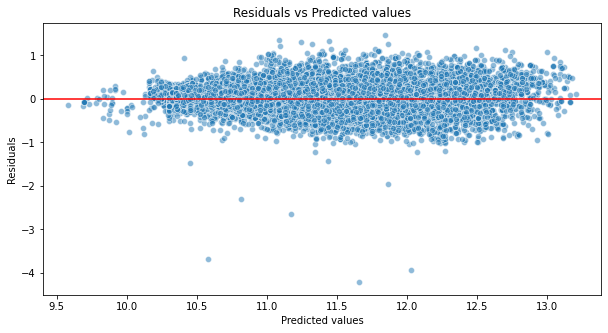

In [260]:
#Plot of predicted values vs residuals
plt.figure(figsize=(10,5))
sns.scatterplot(predicted_values,residuals, alpha = 0.5)
plt.axhline(y=0, c="red")
plt.title("Residuals vs Predicted values")
plt.ylabel("Residuals")
plt.xlabel("Predicted values")
plt.show()


We can see that visually there are not any particular distirbution patterns for the residuals vs predicted values relationship. However there is a slight difference in the variance over different predicted values. Variance of residuals is smaller for the lower priced flats. In spite of these small points, visually the linearity and equal variannce assumption is satisfied. 

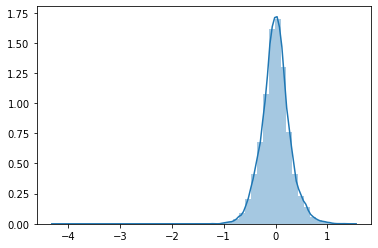

In [196]:
#Normality
#visual presentation- histogram
sns.distplot(residuals)
plt.show()

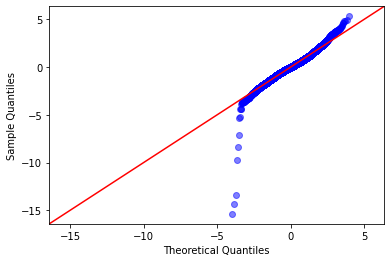

In [197]:
#QQ plot
qqplot(residuals,fit=True, line='45', alpha = 0.5)
plt.show()

#### 5.2 Diagnostic tests

In [198]:
#Linearity 
#The null hypothesis assumes that the regression is correctly modelled as linear
rnames=["fstat", "p-value"]
rainbow=linear_rainbow(results_linear)
print(list(zip(rnames, rainbow)))

[('fstat', 1.0935598227296235), ('p-value', 1.7173001838774013e-08)]


As the p-value is greater than 0.05, there is not enough evidence to claim that the regression is modeled as linear.

In [199]:
#Breusch-Pagan test for homoscedasticity
#The null hypothesis assumes homoskedasticity
bnames = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
breush = het_breuschpagan(residuals, results_linear.model.exog)
print(list(zip(bnames, breush)))

[('Lagrange multiplier statistic', 1451.4535486681054), ('p-value', 6.16281535180124e-293), ('f-value', 66.20957131550222), ('f p-value', 1.9551032570620314e-300)]


Again the p-value is larger than 0.05, so the assumption of homosckesadicity is held.

In [218]:
#Shapiro-Wilk normality test. 
#The null-hypothesis of this test is that the data was drawn from a normal distribution
snames=['The test statistic', 'p-value']
shapiro=shapiro(residuals)
print(list(zip(snames, shapiro)))

[('The test statistic', 0.9784165620803833), ('p-value', 0.0)]


The normality assumption is not satisfied, as the p-value is smaller than 0.05.

In [0]:
#defining colnames 
var=X.columns.tolist()

In [262]:
#Multicollinearity
#calculating vif using variance_inflation_factor() function from statsmodel
vif = [variance_inflation_factor(X[var].values, i) for i in range(0,len(var))]
print(vif)


[12.087028039957888, 144.10634598706037, 15.81034359256927, 1.2987285205097312, 1.6984667839314755, 1.2855884064784127, 2.0921913295878394, 1.513632766093591, 4.161151188918567, 1.724375863691637, 1.1723151003197214, 6.438737624315205, 1.852061143145172, 2.0966252613643293, 2.4385050324978597, 1.560038063067149, 4.4231182194913705, 2.0268369891137987, 41.9968010459217, 72.58517125459218, 72.00453560283461, 36.13944262089612]


In [263]:
#printing vif values together with variable names
for i in range(0,len(var)):
    print(var[i],":",vif[i])

nFloor : 12.087028039957888
Sqm_lg : 144.10634598706037
Sqm/rooms : 15.81034359256927
cent_penthouse : 1.2987285205097312
Source_my_realty : 1.6984667839314755
Source_real_estate : 1.2855884064784127
District_աջափնյակ : 2.0921913295878394
District_ավան : 1.513632766093591
District_արաբկիր : 4.161151188918567
District_դավթաշեն : 1.724375863691637
District_էրեբունի : 1.1723151003197214
District_կենտրոն : 6.438737624315205
District_մալաթիա_սեբաստիա : 1.852061143145172
District_նոր_նորք : 2.0966252613643293
District_շենգավիթ : 2.4385050324978597
District_քանաքեռ_զեյթուն : 1.560038063067149
Type_Այլ : 4.4231182194913705
Type_Կասետային : 2.0268369891137987
Type_Մոնոլիտ : 41.9968010459217
Type_Պանելային : 72.58517125459218
Type_Քարե : 72.00453560283461
Agency_1.0 : 36.13944262089612


Some of the variables are correlated, with a VIF value larger than 10. 

# 6. Clustering

In [246]:
for i in data.District.unique():
  print(i)
  X = data_ols[data.District == i].drop("Price_USD", axis = 1)
  Y = np.log(data[data.District == i].Price_USD)
  X0, X1, Y0, Y1 = train_test_split(X, Y, test_size=0.25, random_state=42)
  model = LinearRegression().fit(X0,Y0)
  Y0_hat = model.predict(X0)
  Y1_hat = model.predict(X1)
  print("R-squared Train:",r2_score(Y0,Y0_hat).round(3))
  print("R-squared Test:",r2_score(Y1,Y1_hat).round(3))



կենտրոն
R-squared Train: 0.622
R-squared Test: 0.65
աջափնյակ
R-squared Train: 0.659
R-squared Test: 0.691
ավան
R-squared Train: 0.819
R-squared Test: 0.805
արաբկիր
R-squared Train: 0.717
R-squared Test: 0.747
դավթաշեն
R-squared Train: 0.719
R-squared Test: 0.704
էրեբունի
R-squared Train: 0.684
R-squared Test: 0.537
նոր_նորք
R-squared Train: 0.702
R-squared Test: 0.713
մալաթիա_սեբաստիա
R-squared Train: 0.542
R-squared Test: 0.544
քանաքեռ_զեյթուն
R-squared Train: 0.657
R-squared Test: 0.668
շենգավիթ
R-squared Train: 0.665
R-squared Test: 0.685
Չկա
R-squared Train: 0.6
R-squared Test: 0.622


In [0]:
#Creating a special model for the Kentron district
data_kentron = data[data.District == 'կենտրոն']
X_kentron = data_kentron.drop(["Price_USD", "Broker", "price_per_sqm", "District", "Rooms", "Sqm", "Floor_lg", "nFloor_lg", "Agency"], axis = 1)
Y_kentron = data_kentron.Price_USD

In [224]:
X_kentron = sm.add_constant(X_kentron)
X_kentron = pd.get_dummies(X_kentron, drop_first=True)
X_kentron = X_kentron.drop(["Type_Կասետային", "Type_Այլ", "Type_Քարե"], axis = 1)
kentron_model = sm.OLS(Y_kentron,X_kentron).fit()
kentron_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Price_USD   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     1301.
Date:                Fri, 15 May 2020   Prob (F-statistic):               0.00
Time:                        14:10:46   Log-Likelihood:            -1.2307e+05
No. Observations:                9730   AIC:                         2.462e+05
Df Residuals:                    9718   BIC:                         2.463e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -2.11e+05   1.75e+04    -12.041      0.000   -2.45e+05   -1.77e+05
nFloor             -3142.7479    530.881     -5.920      0.000   -4183.386   -2102.110
Floor              -1325.0498    734.098     -1.805      0.071   -2764.035     113.936
Sqm/rooms           4220.9473    131.154     32.183      0.000    3963.859    4478.036
F/nF               -8.514e+04   8968.295     -9.493      0.000   -1.03e+05   -6.76e+04
Sqm_lg               4.49e+04   4629.127      9.700      0.000    3.58e+04     5.4e+04
Rooms_Floor         2.625e+04   1042.144     25.185      0.000    2.42e+04    2.83e+04
cent_penthouse      -1.11e+04   2894.416     -3.836      0.000   -1.68e+04   -5428.127
Source_my_realty    1.201e+04   1686.921      7.118      0.000    8701.213    1.53e+04
Source_real_estate  1.889e+04   2256.211      8.374      0.000    1.45e+04    2.33e+04
Type_Մոնոլիտ        3.194e+04   2693.175     11.860      0.000    2.67e+04    3.72e+04
Type_Պանելային     -4.185e+04   2445.193    -17.114      0.000   -4.66e+04   -3.71e+04
==============================================================================
Omnibus:                     3579.207   Durbin-Watson:                   1.760
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34599.728
Skew:                           1.487   Prob(JB):                         0.00
Kurtosis:                      11.746   Cond. No.                         906.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [0]:
#By doing ann individual feature selection for only the "կենտրոն" district dataset. We couldn't get better results. 